In [1]:
!pip install imblearn
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p38/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p38/bin/python -m pip install --upgrade pip' command.


In [2]:
#import neccessary libraries
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
from tensorflow.keras.utils import get_file
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
from collections import Counter
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, precision_recall_curve
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from imblearn.combine import SMOTETomek
import os
from sklearn import metrics
from scipy.stats import zscore
from sklearn import decomposition
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix

2022-11-16 20:06:32.289700: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-16 20:06:32.491493: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


#UNSW_NB15 dataset

In [3]:
unsw_train_full = "UNSW_NB15_training-set.csv"
unsw_test_full = "UNSW_NB15_testing-set.csv"
df_train_unsw = pd.read_csv(unsw_train_full)
df_test_unsw = pd.read_csv(unsw_test_full)

In [4]:
df_test_unsw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 175341 non-null  int64  
 1   dur                175341 non-null  float64
 2   proto              175341 non-null  object 
 3   service            175341 non-null  object 
 4   state              175341 non-null  object 
 5   spkts              175341 non-null  int64  
 6   dpkts              175341 non-null  int64  
 7   sbytes             175341 non-null  int64  
 8   dbytes             175341 non-null  int64  
 9   rate               175341 non-null  float64
 10  sttl               175341 non-null  int64  
 11  dttl               175341 non-null  int64  
 12  sload              175341 non-null  float64
 13  dload              175341 non-null  float64
 14  sloss              175341 non-null  int64  
 15  dloss              175341 non-null  int64  
 16  si

In [5]:
#merge the 2 datasets
frames2 = [df_train_unsw, df_test_unsw]
  
unsw_df = pd.concat(frames2)

In [6]:
#print some insights about the KDD99 dataset
print("Read {} rows.".format(len(unsw_df)))
print('='*40)
print('The number of data points are:', unsw_df.shape[0])
print('='*40)
print('The number of features are:', unsw_df.shape[1])
print('='*40)
output = unsw_df['attack_cat'].values
labels = set(output)
print('The different type of output labels are:', labels)
print('='*125)
print('The number of different output labels are:', len(labels))
print('='*40)
print('='*40)

Read 257673 rows.
The number of data points are: 257673
The number of features are: 45
The different type of output labels are: {'Generic', 'Worms', 'Reconnaissance', 'Fuzzers', 'Normal', 'Shellcode', 'DoS', 'Exploits', 'Analysis', 'Backdoor'}
The number of different output labels are: 10


In [7]:
# Checking for NULL values
print('Null values in dataset are',len(unsw_df[unsw_df.isnull().any(1)]))
print('='*40)

# Checkng for DUPLICATE values
unsw_df.drop_duplicates(keep='first', inplace = True)

# For now, just drop NA's (rows with missing values)
unsw_df.dropna(inplace=True,axis=1) 

print("Read {} rows.".format(len(unsw_df)))
print('='*40)
print('='*40)

Null values in dataset are 0
Read 257673 rows.


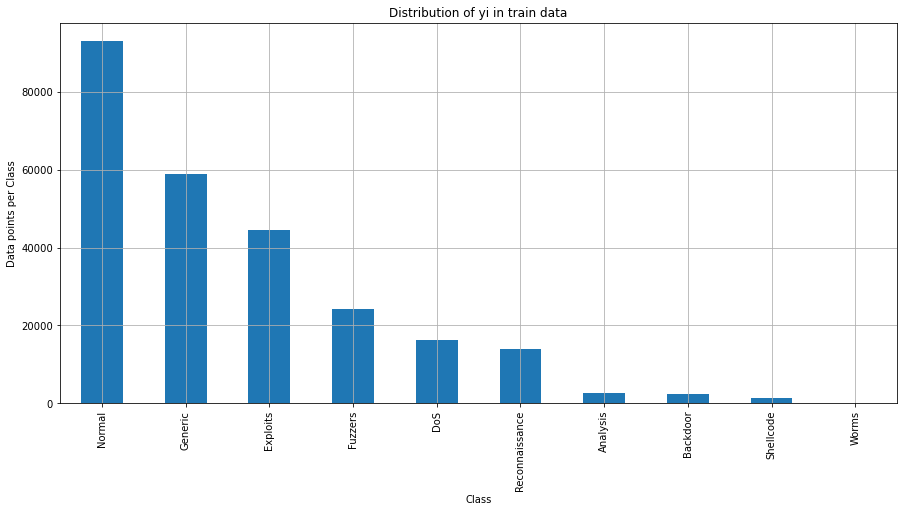

In [8]:
plt.figure(figsize=(15,7))
class_distribution = unsw_df['attack_cat'].value_counts()
class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

In [9]:
sorted_yi = np.argsort(-class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', class_distribution.index[i],':', class_distribution.values[i], 
          '(', np.round((class_distribution.values[i]/unsw_df.shape[0]*100), 3), '%)')

Number of data points in class Normal : 93000 ( 36.092 %)
Number of data points in class Generic : 58871 ( 22.847 %)
Number of data points in class Exploits : 44525 ( 17.28 %)
Number of data points in class Fuzzers : 24246 ( 9.41 %)
Number of data points in class DoS : 16353 ( 6.346 %)
Number of data points in class Reconnaissance : 13987 ( 5.428 %)
Number of data points in class Analysis : 2677 ( 1.039 %)
Number of data points in class Backdoor : 2329 ( 0.904 %)
Number of data points in class Shellcode : 1511 ( 0.586 %)
Number of data points in class Worms : 174 ( 0.068 %)


#Some preprocessing

In [10]:
unsw_df['attack_cat'].unique()

array(['Normal', 'Reconnaissance', 'Backdoor', 'DoS', 'Exploits',
       'Analysis', 'Fuzzers', 'Worms', 'Shellcode', 'Generic'],
      dtype=object)

##Apply onehot encoding to the categorical columns

In [11]:
ENCODING = 'utf-8'

def expand_categories(values):
    result = []
    s = values.value_counts()
    t = float(len(values))
    for v in s.index:
        result.append("{}:{}%".format(v,round(100*(s[v]/t),2)))
    return "[{}]".format(",".join(result))
        
def analyze(df):
    print()
    cols = df.columns.values
    total = float(len(df))

    print("{} rows".format(int(total)))
    for col in cols:
        uniques = df[col].unique()
        unique_count = len(uniques)
        if unique_count>100:
            print("** {}:{} ({}%)".format(col,unique_count,int(((unique_count)/total)*100)))
        else:
            print("** {}:{}".format(col,expand_categories(df[col])))
            expand_categories(df[col])

In [12]:
analyze(unsw_df)


257673 rows
** id:175341 (68%)
** dur:109945 (42%)
** proto:133 (0%)
** service:[-:54.85%,dns:26.65%,http:10.48%,smtp:2.68%,ftp-data:2.09%,ftp:1.93%,pop3:0.59%,ssh:0.58%,dhcp:0.05%,snmp:0.04%,ssl:0.03%,irc:0.01%,radius:0.01%]
** state:[FIN:45.47%,INT:45.19%,CON:7.81%,REQ:1.49%,RST:0.03%,ECO:0.0%,ACC:0.0%,CLO:0.0%,PAR:0.0%,URN:0.0%,no:0.0%]
** spkts:646 (0%)
** dpkts:627 (0%)
** sbytes:9382 (3%)
** dbytes:8653 (3%)
** rate:115763 (44%)
** sttl:[254:65.51%,31:21.79%,62:10.89%,0:1.63%,64:0.07%,1:0.04%,29:0.02%,255:0.01%,63:0.01%,60:0.01%,32:0.01%,30:0.0%,252:0.0%]
** dttl:[0:46.74%,252:31.02%,29:21.78%,60:0.42%,30:0.02%,31:0.01%,253:0.0%,32:0.0%,254:0.0%]
** sload:121356 (47%)
** dload:116380 (45%)
** sloss:490 (0%)
** dloss:476 (0%)
** sinpkt:114318 (44%)
** dinpkt:110270 (42%)
** sjit:117101 (45%)
** djit:114861 (44%)
** swin:[0:52.25%,255:47.74%,167:0.0%,168:0.0%,172:0.0%,87:0.0%,45:0.0%,103:0.0%,192:0.0%,14:0.0%,232:0.0%,31:0.0%,43:0.0%,245:0.0%,52:0.0%,154:0.0%,67:0.0%,5:0.0%,99:0.0

In [13]:
# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

In [14]:
# Now encode the feature vector

encode_numeric_zscore(unsw_df, 'id')
encode_numeric_zscore(unsw_df, 'dur')
encode_text_dummy(unsw_df, 'proto')
encode_text_dummy(unsw_df, 'service')
encode_text_dummy(unsw_df, 'state')
encode_numeric_zscore(unsw_df, 'spkts')
encode_numeric_zscore(unsw_df, 'dpkts')
encode_numeric_zscore(unsw_df, 'sbytes')
encode_numeric_zscore(unsw_df, 'dbytes')
encode_numeric_zscore(unsw_df, 'rate')
encode_numeric_zscore(unsw_df, 'sttl')
encode_numeric_zscore(unsw_df, 'dttl')
encode_numeric_zscore(unsw_df, 'sload')
encode_numeric_zscore(unsw_df, 'dload')
encode_numeric_zscore(unsw_df, 'sloss')
encode_numeric_zscore(unsw_df, 'dloss')
encode_numeric_zscore(unsw_df, 'sinpkt')
encode_numeric_zscore(unsw_df, 'dinpkt')
encode_numeric_zscore(unsw_df, 'sjit')
encode_numeric_zscore(unsw_df, 'djit')
encode_numeric_zscore(unsw_df, 'swin')
encode_numeric_zscore(unsw_df, 'stcpb')
encode_numeric_zscore(unsw_df, 'dtcpb')
encode_numeric_zscore(unsw_df, 'dwin')
encode_numeric_zscore(unsw_df, 'tcprtt')
encode_numeric_zscore(unsw_df, 'synack')
encode_numeric_zscore(unsw_df, 'ackdat')
encode_numeric_zscore(unsw_df, 'smean')
encode_numeric_zscore(unsw_df, 'dmean')
encode_numeric_zscore(unsw_df, 'trans_depth')
encode_numeric_zscore(unsw_df, 'response_body_len')
encode_numeric_zscore(unsw_df, 'ct_srv_src')
encode_numeric_zscore(unsw_df, 'ct_state_ttl')
encode_numeric_zscore(unsw_df, 'ct_dst_ltm')
encode_numeric_zscore(unsw_df, 'ct_src_dport_ltm')
encode_numeric_zscore(unsw_df, 'ct_dst_sport_ltm')
encode_numeric_zscore(unsw_df, 'ct_dst_src_ltm')
encode_numeric_zscore(unsw_df, 'is_ftp_login')
encode_numeric_zscore(unsw_df, 'ct_ftp_cmd')
encode_numeric_zscore(unsw_df, 'ct_flw_http_mthd')
encode_numeric_zscore(unsw_df, 'ct_src_ltm')
encode_numeric_zscore(unsw_df, 'ct_srv_dst')
encode_numeric_zscore(unsw_df, 'is_sm_ips_ports')
encode_numeric_zscore(unsw_df, 'label')

# display 5 rows

unsw_df.dropna(inplace=True,axis=1)
unsw_df[0:5] 
# This is the numeric feature vectorF

/tmp/ipykernel_13879/2704301981.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[dummy_name] = dummies[x]


,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,state-CLO,state-CON,state-ECO,state-FIN,state-INT,state-PAR,state-REQ,state-RST,state-URN,state-no
0,-1.488063,-0.208678,-0.130765,-0.165331,-0.046480,-0.098409,-0.002151,0.722025,-0.751626,0.590934,...,0,0,0,0,1,0,0,0,0,0
1,-1.488043,-0.208678,-0.130765,-0.165331,-0.039194,-0.098409,0.210460,0.722025,-0.751626,4.363247,...,0,0,0,0,1,0,0,0,0,0
2,-1.488023,-0.208679,-0.130765,-0.165331,-0.043188,-0.098409,0.678202,0.722025,-0.751626,4.220029,...,0,0,0,0,1,0,0,0,0,0
3,-1.488002,-0.208679,-0.130765,-0.165331,-0.044155,-0.098409,0.470317,0.722025,-0.751626,2.850308,...,0,0,0,0,1,0,0,0,0,0
4,-1.487982,-0.208678,-0.130765,-0.165331,-0.037100,-0.098409,0.054546,0.722025,-0.751626,4.198493,...,0,0,0,0,1,0,0,0,0,0


#SMOTE

In [15]:
x = unsw_df.drop(['attack_cat'], axis=1)
y = unsw_df['attack_cat']

In [16]:
counter = Counter(y)
print('Before',counter)
# oversampling the train dataset using SMOTE
sm = SMOTE(sampling_strategy= 'not majority',k_neighbors= 1)
X_sm, y_sm = sm.fit_resample(x, y)
counter = Counter(y_sm)
print('After',counter)

Before Counter({'Normal': 93000, 'Generic': 58871, 'Exploits': 44525, 'Fuzzers': 24246, 'DoS': 16353, 'Reconnaissance': 13987, 'Analysis': 2677, 'Backdoor': 2329, 'Shellcode': 1511, 'Worms': 174})
After Counter({'Normal': 93000, 'Reconnaissance': 93000, 'Backdoor': 93000, 'DoS': 93000, 'Exploits': 93000, 'Analysis': 93000, 'Fuzzers': 93000, 'Worms': 93000, 'Shellcode': 93000, 'Generic': 93000})


##RF + similarity optimization

In [ ]:
std_slc = StandardScaler()
pca = decomposition.PCA()
dtree = RandomForestClassifier()
pipe = Pipeline(steps=[("std_slc", std_slc),("pca", pca),("dtree", dtree)])
n_components = list(range(1,X_sm.shape[1]+1,1))
criterion = ["friedman_mse", "mse"]
max_depth = [4,6,8,10]
parameters = dict(pca__n_components=n_components,dtree__criterion=criterion,dtree__max_depth=max_depth)
          
clf = GridSearchCV(pipe, parameters)
clf.fit(X_sm, y_sm)

print("Best Number Of Components:", clf.best_estimator_.get_params()["pca__n_components"])
print(); print(clf.best_estimator_.get_params()["dtreeReg"])

CV_Result = cross_val_score(clf, X_sm, y_sm, cv=3, n_jobs=-1, scoring="r2")
print(); print(CV_Result)
print(); print(CV_Result.mean())
print(); print(CV_Result.std())

#split the dataset

In [17]:
# Splitting the data into train and test
X_train,X_test,y_train,y_test=train_test_split(x, y, train_size=0.7, random_state=100)

X_train_sm,X_test_sm,y_train_sm,y_test_sm=train_test_split(X_sm, y_sm, train_size=0.7, random_state=100)

#Train models on the unnormalized dataset

In [19]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)
y_pred_knn = neigh.predict(X_test)
print(y_pred_knn)

['DoS' 'Generic' 'Generic' ... 'Normal' 'Reconnaissance' 'Normal']


/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


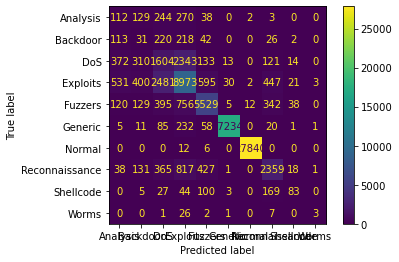

In [20]:
#confusion_matrix(y_test, y_pred_knn)
from sklearn.metrics import plot_confusion_matrix
cnf_matrix=confusion_matrix(y_test,y_pred_knn)
plot_confusion_matrix(neigh, X_test, y_test)
plt.show()

In [21]:
print(classification_report(y_test, y_pred_knn))

                precision    recall  f1-score   support

      Analysis       0.09      0.14      0.11       798
      Backdoor       0.03      0.05      0.03       652
           DoS       0.30      0.33      0.31      4910
      Exploits       0.66      0.67      0.66     13483
       Fuzzers       0.80      0.75      0.78      7326
       Generic       1.00      0.98      0.99     17647
        Normal       1.00      1.00      1.00     27858
Reconnaissance       0.68      0.57      0.62      4157
     Shellcode       0.47      0.19      0.27       431
         Worms       0.38      0.07      0.12        40

      accuracy                           0.82     77302
     macro avg       0.54      0.47      0.49     77302
  weighted avg       0.84      0.82      0.83     77302



In [18]:
rf_clf = RandomForestClassifier(max_depth=2, random_state=0)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, random_state=0)

In [19]:
y_pred_rf = rf_clf.predict(X_test)

/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


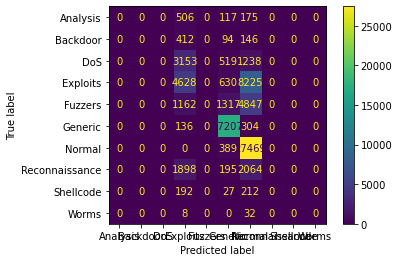

In [20]:
cnf_matrix=confusion_matrix(y_test,y_pred_rf)
plot_confusion_matrix(rf_clf, X_test, y_test)
plt.show()

In [21]:
print(classification_report(y_test, y_pred_rf))

/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

      Analysis       0.00      0.00      0.00       798
      Backdoor       0.00      0.00      0.00       652
           DoS       0.00      0.00      0.00      4910
      Exploits       0.38      0.34      0.36     13483
       Fuzzers       0.00      0.00      0.00      7326
       Generic       0.84      0.98      0.90     17647
        Normal       0.61      0.99      0.76     27858
Reconnaissance       0.00      0.00      0.00      4157
     Shellcode       0.00      0.00      0.00       431
         Worms       0.00      0.00      0.00        40

      accuracy                           0.64     77302
     macro avg       0.18      0.23      0.20     77302
  weighted avg       0.48      0.64      0.54     77302



/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#Train models on normalized dataset with SMOTE

In [22]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train_sm, y_train_sm)
y_pred_knn = neigh.predict(X_test_sm)
print(y_pred_knn)

['Generic' 'Fuzzers' 'Backdoor' ... 'DoS' 'DoS' 'Backdoor']


/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


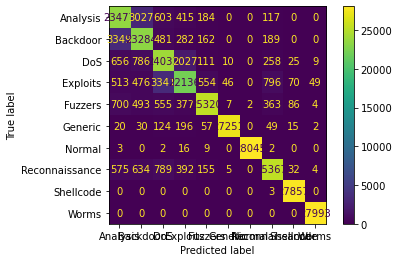

In [23]:
#confusion_matrix(y_test, y_pred_knn)
from sklearn.metrics import plot_confusion_matrix
cnf_matrix=confusion_matrix(y_test_sm,y_pred_knn)
plot_confusion_matrix(neigh, X_test_sm, y_test_sm)
plt.show()

In [24]:
print(classification_report(y_test_sm, y_pred_knn))

                precision    recall  f1-score   support

      Analysis       0.80      0.84      0.82     27823
      Backdoor       0.81      0.84      0.82     27747
           DoS       0.80      0.86      0.83     27915
      Exploits       0.86      0.79      0.82     27981
       Fuzzers       0.95      0.91      0.93     27907
       Generic       1.00      0.98      0.99     27744
        Normal       1.00      1.00      1.00     28077
Reconnaissance       0.93      0.91      0.92     27953
     Shellcode       0.99      1.00      1.00     27860
         Worms       1.00      1.00      1.00     27993

      accuracy                           0.91    279000
     macro avg       0.91      0.91      0.91    279000
  weighted avg       0.91      0.91      0.91    279000



In [25]:
rf_clf = RandomForestClassifier(max_depth=3, random_state=0)
rf_clf.fit(X_train_sm, y_train_sm)

RandomForestClassifier(max_depth=3, random_state=0)

In [26]:
y_pred_rf = rf_clf.predict(X_test_sm)

/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


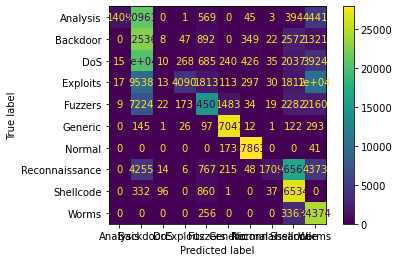

In [27]:
cnf_matrix=confusion_matrix(y_test_sm,y_pred_rf)
plot_confusion_matrix(rf_clf, X_test_sm, y_test_sm)
plt.show()

In [28]:
print(classification_report(y_test_sm, y_pred_rf))

                precision    recall  f1-score   support

      Analysis       0.97      0.05      0.10     27823
      Backdoor       0.26      0.81      0.40     27747
           DoS       0.06      0.00      0.00     27915
      Exploits       0.89      0.15      0.25     27981
       Fuzzers       0.71      0.52      0.60     27907
       Generic       0.92      0.97      0.95     27744
        Normal       0.96      0.99      0.98     28077
Reconnaissance       0.92      0.06      0.11     27953
     Shellcode       0.48      0.95      0.64     27860
         Worms       0.48      0.87      0.62     27993

      accuracy                           0.54    279000
     macro avg       0.66      0.54      0.46    279000
  weighted avg       0.67      0.54      0.46    279000



#SMOTE + ENN

In [13]:
counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using SMOTE + ENN
X_temp = pd.concat([X_train_sm, X_test_sm], axis=0)
y_temp = pd.concat([y_train_sm, y_test_sm], axis=0)
X_train_temp,X_test_temp,y_train_temp,y_test_temp=train_test_split(X_temp, y_temp, train_size=0.98, random_state=100)

smm = SMOTE(sampling_strategy= 'not majority',k_neighbors= 1)
smenn = SMOTEENN(sampling_strategy= 'not majority', smote = smm)
X_smenn, y_smenn = smenn.fit_resample(X_train_temp, y_train_temp)
counter = Counter(y_smenn)
print('After',counter)

X_x = pd.concat([X_smenn, X_test_temp], axis=0)
y_y = pd.concat([y_smenn, y_test_temp], axis=0)
X_train_smenn,X_test_smenn,y_train_smenn,y_test_smenn=train_test_split(X_x, y_y, train_size=0.7, random_state=100)

After Counter({'Worms': 91178, 'Shellcode': 91171, 'Normal': 91078, 'Generic': 89221, 'Fuzzers': 81412, 'Reconnaissance': 80863, 'DoS': 68641, 'Exploits': 66630, 'Analysis': 63741, 'Backdoor': 62661})


#models after normalization using: SMOTE + ENN

In [18]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train_smenn, y_train_smenn)
y_pred_knn = neigh.predict(X_test_sm)
print(y_pred_knn)

['Generic' 'Fuzzers' 'Backdoor' ... 'DoS' 'DoS' 'Backdoor']


/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


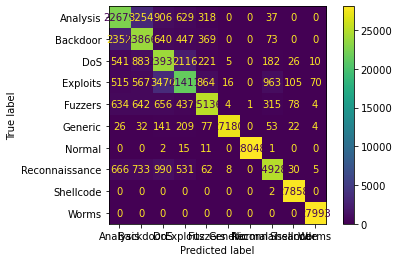

In [19]:
cnf_matrix=confusion_matrix(y_test_sm,y_pred_knn)
plot_confusion_matrix(neigh, X_test_sm, y_test_sm)
plt.show()

In [20]:
print(classification_report(y_test_sm, y_pred_knn))

                precision    recall  f1-score   support

      Analysis       0.83      0.82      0.82     27823
      Backdoor       0.80      0.86      0.83     27747
           DoS       0.78      0.86      0.82     27915
      Exploits       0.83      0.77      0.80     27981
       Fuzzers       0.93      0.90      0.91     27907
       Generic       1.00      0.98      0.99     27744
        Normal       1.00      1.00      1.00     28077
Reconnaissance       0.94      0.89      0.91     27953
     Shellcode       0.99      1.00      1.00     27860
         Worms       1.00      1.00      1.00     27993

      accuracy                           0.91    279000
     macro avg       0.91      0.91      0.91    279000
  weighted avg       0.91      0.91      0.91    279000



In [14]:
rf_clf = RandomForestClassifier(max_depth=3, random_state=0)
rf_clf.fit(X_train_smenn, y_train_smenn)

RandomForestClassifier(max_depth=3, random_state=0)

In [15]:
y_pred_rf = rf_clf.predict(X_test_sm)

/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


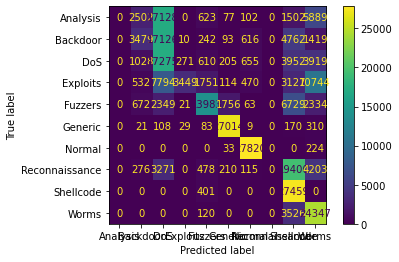

In [16]:
cnf_matrix=confusion_matrix(y_test_sm,y_pred_rf)
plot_confusion_matrix(rf_clf, X_test_sm, y_test_sm)
plt.show()

In [17]:
print(classification_report(y_test_sm, y_pred_rf))

/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

      Analysis       0.00      0.00      0.00     27823
      Backdoor       0.41      0.13      0.19     27747
           DoS       0.27      0.62      0.37     27915
      Exploits       0.91      0.12      0.22     27981
       Fuzzers       0.76      0.50      0.61     27907
       Generic       0.92      0.97      0.94     27744
        Normal       0.93      0.99      0.96     28077
Reconnaissance       0.00      0.00      0.00     27953
     Shellcode       0.39      0.99      0.56     27860
         Worms       0.46      0.87      0.60     27993

      accuracy                           0.52    279000
     macro avg       0.50      0.52      0.44    279000
  weighted avg       0.50      0.52      0.44    279000



/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#SMOTE+Tomek links

In [21]:
counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using SMOTE + Tomek
X_temp = pd.concat([X_train_sm, X_test_sm], axis=0)
y_temp = pd.concat([y_train_sm, y_test_sm], axis=0)
X_train_temp,X_test_temp,y_train_temp,y_test_temp=train_test_split(X_temp, y_temp, train_size=0.98, random_state=100)

smtom = SMOTETomek(random_state=139)
X_smtom, y_smtom = smtom.fit_resample(X_train_temp, y_train_temp)

counter = Counter(y_smtom)
print('After',counter)


X_x = pd.concat([X_smtom, X_test_temp], axis=0)
y_y = pd.concat([y_smtom, y_test_temp], axis=0)
X_train_smtom,X_test_smtom,y_train_smtom,y_test_smtom=train_test_split(X_x, y_y, train_size=0.7, random_state=100)

Before Counter({'Normal': 65142, 'Generic': 41224, 'Exploits': 31042, 'Fuzzers': 16920, 'DoS': 11443, 'Reconnaissance': 9830, 'Analysis': 1879, 'Backdoor': 1677, 'Shellcode': 1080, 'Worms': 134})
After Counter({'Normal': 91192, 'Shellcode': 91190, 'Worms': 91190, 'Generic': 91003, 'Fuzzers': 88726, 'Reconnaissance': 88274, 'Exploits': 86148, 'DoS': 84393, 'Analysis': 82732, 'Backdoor': 82270})


#models after normalization using: SMOTE + Tomek links

In [26]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train_smtom, y_train_smtom)
y_pred_knn = neigh.predict(X_test_sm)
print(y_pred_knn)

['Generic' 'Fuzzers' 'Backdoor' ... 'DoS' 'DoS' 'Backdoor']


/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


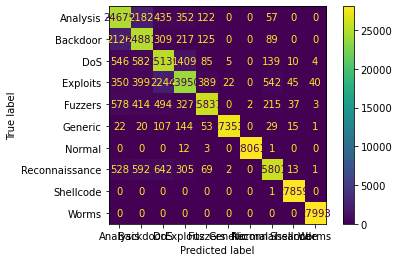

In [27]:
cnf_matrix=confusion_matrix(y_test_sm,y_pred_knn)
plot_confusion_matrix(neigh, X_test_sm, y_test_sm)
plt.show()

In [28]:
print(classification_report(y_test_sm, y_pred_knn))

                precision    recall  f1-score   support

      Analysis       0.86      0.89      0.87     27823
      Backdoor       0.86      0.90      0.88     27747
           DoS       0.86      0.90      0.88     27915
      Exploits       0.90      0.86      0.88     27981
       Fuzzers       0.97      0.93      0.95     27907
       Generic       1.00      0.99      0.99     27744
        Normal       1.00      1.00      1.00     28077
Reconnaissance       0.96      0.92      0.94     27953
     Shellcode       1.00      1.00      1.00     27860
         Worms       1.00      1.00      1.00     27993

      accuracy                           0.94    279000
     macro avg       0.94      0.94      0.94    279000
  weighted avg       0.94      0.94      0.94    279000



In [22]:
rf_clf = RandomForestClassifier(max_depth=3, random_state=0)
rf_clf.fit(X_train_smtom, y_train_smtom)

RandomForestClassifier(max_depth=3, random_state=0)

In [23]:
y_pred_rf = rf_clf.predict(X_test_sm)

/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


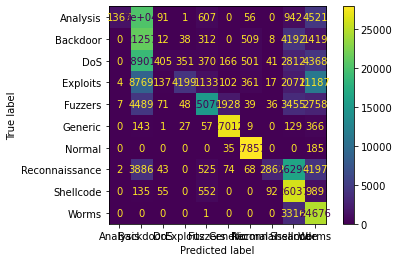

In [24]:
cnf_matrix=confusion_matrix(y_test_sm,y_pred_rf)
plot_confusion_matrix(rf_clf, X_test_sm, y_test_sm)
plt.show()

In [25]:
print(classification_report(y_test_sm, y_pred_rf))

                precision    recall  f1-score   support

      Analysis       0.99      0.05      0.09     27823
      Backdoor       0.27      0.77      0.40     27747
           DoS       0.50      0.01      0.03     27915
      Exploits       0.90      0.15      0.26     27981
       Fuzzers       0.81      0.54      0.65     27907
       Generic       0.92      0.97      0.95     27744
        Normal       0.95      0.99      0.97     28077
Reconnaissance       0.94      0.10      0.18     27953
     Shellcode       0.44      0.93      0.60     27860
         Worms       0.45      0.88      0.60     27993

      accuracy                           0.54    279000
     macro avg       0.72      0.54      0.47    279000
  weighted avg       0.72      0.54      0.47    279000

